<h1>Food Delivery From Restaurants

<h3><i> Getting the Restaurants information from the Foursqaure API.

Import required packages for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import geopy
import requests
import folium

Define Foursquare Credentials and Version

In [411]:
#Define Foursquare Credentials and Version
CLIENT_ID ='ABCD'  # your Foursquare ID
CLIENT_SECRET = 'MNMN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)


For the example usecase , Consider 'New York City,NY' for putting the food delivery business and assume the centre location as the freight provider office

In [140]:
address = 'New York City, NY'
geolocator = geopy.geocoders.Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {} which we consider as the freight provider''s office location.'.format(latitude, longitude))


The geograpical coordinate of New York City are 40.7127281, -74.0060152 which we consider as the freight providers office location.


Prepare the url to fetch all the venues around the radius 1000 and max vanues as 500

In [142]:
radius=1000
LIMIT=500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, VERSION,latitude,longitude,radius,LIMIT);
#url


Get the results (locations) from the FourSqaure API

In [5]:
results = requests.get(url).json()

Know the category of the values to select the restaurants only for our food delivery buisiness

In [6]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Clean up the results and store the data in pandas dataframe

In [7]:
#Now we are ready to clean the json and structure it into a *pandas* dataframe.
venues = results['response']['groups'][0]['items']  
nearby_venues = pd.io.json.json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


Create restaurants only dataframe 

In [413]:
nearby_rests=nearby_venues[nearby_venues.categories.str.contains('Rest')].reset_index(drop=True)
print('{} restaurants locations returned by Foursquare.'.format(nearby_rests.shape[0]))
nearby_rests

23 restaurants locations returned by Foursquare.


,name,categories,lat,lng
0,Augustine,French Restaurant,40.711310,-74.006660
1,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994
2,Racines,French Restaurant,40.714754,-74.007581
3,Nish Nūsh,Falafel Restaurant,40.715537,-74.007725
4,Nobu Downtown,Japanese Restaurant,40.710532,-74.009593
5,Chick-fil-A,Fast Food Restaurant,40.710419,-74.008550
6,Nish Nush,Falafel Restaurant,40.709418,-74.008056
7,Little Park,American Restaurant,40.715487,-74.009133
8,Atera,Molecular Gastronomy Restaurant,40.716752,-74.005712
9,Takahachi,Sushi Restaurant,40.716526,-74.008101


In [9]:
from geopy.geocoders import Nominatim 
# function to get the latitude and longitude for a locations
def get_lat_long(Address):
    geolocator = Nominatim(user_agent='a')
    location = geolocator.geocode(Address) 
    return(location.latitude, location.longitude)

Plot the location of the restaurants on map

In [412]:
# create map of Toronto using latitude and longitude values
import folium
latitude,longitude=get_lat_long('New York City, NY')
#print(latitude,longitude)
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=16)#,tiles='cartodb positron')
# add markers to map
for lat, lng, name,categories in zip(nearby_rests['lat'], nearby_rests['lng'], nearby_rests['name'],nearby_rests['categories']):
    label = '{},{}'.format(name,categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

<h3><i>Orders Delivery Planning - 
    1, Clustering the restaurants for delivery,based on their locations

Import the required packages for clustering activities ( K-mean clustering) 

In [11]:
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt # plotting library

Define the data for the clustering - Note , here only location information is used for the clustering this can be enhanced for priority delivery , food temperature zone,quantity of order etc..

In [12]:
# Prepare the Data for the k-mean clustering
X=nearby_rests[['lat','lng']]

<b><u>a.  Evaluate the number of clusters to be formed</b>
-  We have to find the appropriate number of clusters which reduce the sum of square distance thus distinct clean clusters.

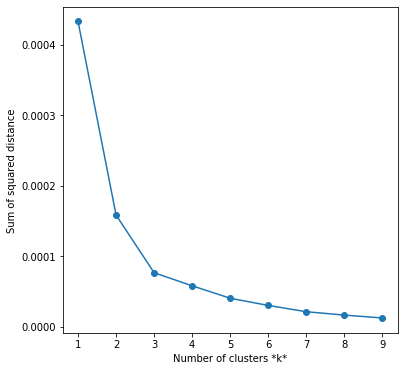

In [13]:
# Evaluate the number of clusters to be formed for least squared distance
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');


By looking as the above graph we can  make use of number of clusters as 5 for better and dictinct clusters

<b>b,Create 5 clusters with K-mean algorithm

In [26]:
k_means = KMeans(init="k-means++", n_clusters=5, n_init=16)
k_means.fit(X)
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
print ('clusters ] \n',k_means_labels ,'\n') ;
print('cluster centers \n' ,k_means_cluster_centers);

clusters ] 
 [1 0 0 0 1 1 1 0 4 0 0 0 0 0 0 0 1 2 4 2 3 2 2] 

cluster centers 
 [[ 40.71581989 -74.00858947]
 [ 40.71022055 -74.00857016]
 [ 40.70736771 -74.00874486]
 [ 40.71442343 -73.99890393]
 [ 40.71734453 -74.00570315]]


In [146]:
# Update nearby_rests with 'Clusters' column.
nearby_rests['Clusters']=pd.DataFrame(k_means_labels)
nearby_rests.head()


,name,categories,lat,lng,Clusters
0,Augustine,French Restaurant,40.711310,-74.006660,1
1,Aahar Indian Cuisine,Indian Restaurant,40.713307,-74.007994,0
2,Racines,French Restaurant,40.714754,-74.007581,0
3,Nish Nūsh,Falafel Restaurant,40.715537,-74.007725,0
4,Nobu Downtown,Japanese Restaurant,40.710532,-74.009593,1


In [148]:
# Visualiza the created clusters
import folium
latitude,longitude=get_lat_long('New York City, NY')
#print(latitude,longitude)
map_newyork_clust = folium.Map(location=[latitude, longitude], zoom_start=16,tiles='cartodb positron')
cl=['#FF33EF','yellow','black','red','#33FF5D','#FFA833','#FF5733','#3AFF33','#FC33FF','#F9FF33','#3357FF']

for lat, lng, clust, name,categories in zip(nearby_rests['lat'], nearby_rests['lng'],nearby_rests['Clusters'], nearby_rests['name'],nearby_rests['categories']):
    label = '{},{},{}'.format(clust,name,categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=cl[clust],
        fill_opacity=1,
        parse_html=False).add_to(map_newyork_clust)  
    
map_newyork_clust


<h3><i>Orders delievery Planning - 
    2, Identifying the customers locations for the restaurants

The Customers locations for the above created restaurant clusters can be abtained dynamically from the restauran online portal, Here random nearby location is considered as the customer location, in actual implementation we have get this info from the online restaurant portal.

In [242]:

# Import numpy for the random number generation.
import numpy as np

# Update the Locations master dataframe to have all the restaurants and customer locations 
All_Locations=""
All_Locations=pd.DataFrame([nearby_rests.name+"_Customer",nearby_rests.categories+"_Customer",nearby_rests.lat+np.random.uniform(0.0001,0.001),nearby_rests.lng-np.random.uniform(0.0001,0.001),nearby_rests.Clusters]).T
All_Locations.head()
All_Locations=All_Locations.append(nearby_rests,ignore_index=True)
print(All_Locations.shape)
All_Locations.head()

(46, 5)


,name,categories,lat,lng,Clusters
0,Augustine_Customer,French Restaurant_Customer,40.7118,-74.0073,1
1,Aahar Indian Cuisine_Customer,Indian Restaurant_Customer,40.7138,-74.0087,0
2,Racines_Customer,French Restaurant_Customer,40.7152,-74.0083,0
3,Nish Nūsh_Customer,Falafel Restaurant_Customer,40.716,-74.0084,0
4,Nobu Downtown_Customer,Japanese Restaurant_Customer,40.711,-74.0103,1


Restaurants and Customers visualization, The Yellow circles represents the customers.

In [243]:
# create map of Toronto using latitude and longitude values
import folium
latitude,longitude=get_lat_long('New York City, NY')
#print(latitude,longitude)
map_newyork_clust_withCustomer = folium.Map(location=[latitude, longitude], zoom_start=16,tiles='cartodb positron')
cl=['#FF33EF','yellow','black','red','#33FF5D','#FFA833','#FF5733','#3AFF33','#FC33FF','#F9FF33','#3357FF']


cust_loc=All_Locations[All_Locations['name'].str.endswith('Customer')]
Rest_loc=All_Locations[All_Locations['categories'].str.endswith('Restaurant')]


for lat, lng, clust, name,categories in zip(Rest_loc['lat'], Rest_loc['lng'],Rest_loc['Clusters'], Rest_loc['name'],Rest_loc['categories']):
    label = '{},{},{}'.format(clust,name,categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=cl[clust],
        fill_opacity=1,
        parse_html=False).add_to(map_newyork_clust_withCustomer)  
    
for lat, lng, clust, name,categories in zip(cust_loc['lat'], cust_loc['lng'],cust_loc['Clusters'], cust_loc['name'],cust_loc['categories']):
    label = '{},{},{}'.format(clust,name,categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#F3FF33',
        fill=True,
        fill_color='#F3FF33',
        fill_opacity=1,
        parse_html=False).add_to(map_newyork_clust_withCustomer)  
map_newyork_clust_withCustomer


<h3><i>Orders delivery Planning - 
    3, Orders consolidations of the restaurants </i></h3> Single order from all the customers is assumed with quantity =1
    
    
    
    

In [233]:
Cust_order=pd.DataFrame(Locations[Locations['categories'].str.endswith('Restaurant')].name).reset_index(drop=True)
Cust_order.rename(columns={'name':'Source'},inplace=True)
Cust_order['Destination']=Cust_order['Source']+"_Customer"
Cust_order['Qty']=1
Cust_order.head()

,Source,Destination,Qty
0,Augustine,Augustine_Customer,1
1,Aahar Indian Cuisine,Aahar Indian Cuisine_Customer,1
2,Racines,Racines_Customer,1
3,Nish Nūsh,Nish Nūsh_Customer,1
4,Nobu Downtown,Nobu Downtown_Customer,1


<h3>Cluster wise Route Optimization

<b>The fuction to get the TSP output from simulated anneling

In [317]:
import random, numpy, math, copy, matplotlib.pyplot as plt
import pandas as pd
def get_tour(cities,tour):
    for temperature in numpy.logspace(0,5,num=100000)[::-1]:
        [i,j] = sorted(random.sample(range(len(cities)),2));
        newTour =  tour[:i] + tour[j:j+1] +  tour[i+1:j] + tour[i:i+1] + tour[j+1:];
        if math.exp( ( sum([ math.sqrt(sum([(cities[tour[(k+1) % len(cities)]][d] - cities[tour[k % len(cities)]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]]) - sum([ math.sqrt(sum([(cities[newTour[(k+1) % len(cities)]][d] - cities[newTour[k % len(cities)]][d])**2 for d in [0,1] ])) for k in [j,j-1,i,i-1]])) / temperature) > random.random():
            tour = copy.copy(newTour);
    #plt.plot([cities[tour[i % len(cities)]][0] for i in range(len(cities)+1)], [cities[tour[i % len(cities)]][1] for i in range(len(cities)+1)], 'xb-');
    #plt.show()
    return tour;


In [318]:
# funaction to calculate the distance between two locations
def find_dist(x1,y1,x2,y2):
    dist=math.sqrt((x1-x2)**2+(y1-y2)**2)
    return dist


In [319]:
# find the location with min distance from a location
def find_min_dist_loc(source,destinations):
    destinations['Dist']=""
    for i in range(destinations.shape[0]):
        destinations.iloc[i,3]=find_dist(source.iloc[0,1],source.iloc[0,2],destinations.iloc[i,1],destinations.iloc[i,2])
    print('Distances',destinations)    
    return destinations[destinations['Dist']==destinations['Dist'].min()][['Locname','Lat','Lang']].drop_duplicates()
    

<h1>Optimization of delivery route for cluster # 0

In [363]:
Locations=All_Locations[All_Locations['Clusters']==0][['name','lat','lng']]
Locations.rename(columns={'name':'Locname','lat':'Lat','lng':'Lang'},inplace=True)
Locations=Locations.reset_index(drop=True)
Locations

,Locname,Lat,Lang
0,Aahar Indian Cuisine_Customer,40.7138,-74.0087
1,Racines_Customer,40.7152,-74.0083
2,Nish Nūsh_Customer,40.716,-74.0084
3,Little Park_Customer,40.716,-74.0098
4,Takahachi_Customer,40.717,-74.0088
5,Juice Press_Customer,40.7153,-74.0118
6,Tiny's and the Bar Upstairs_Customer,40.7173,-74.0089
7,Khe-Yo_Customer,40.7172,-74.0093
8,Restaurant Marc Forgione_Customer,40.7169,-74.0103
9,Sushi of Gari Tribeca_Customer,40.7172,-74.009


In [364]:
import random, numpy, math, copy, matplotlib.pyplot as plt

Rest_only_loc=Locations[Locations['Locname'].str.endswith('_Customer')==False].reset_index(drop=True)
Rest_Cust_list=[]
for x in range(Rest_only_loc.shape[0]):
    Rest_Cust_list.append([Rest_only_loc['Lat'][x],Rest_only_loc['Lang'][x]])
tour = random.sample(range(len(Rest_Cust_list)),len(Rest_Cust_list));
a=get_tour(Rest_Cust_list,tour)
Locations_tours=Rest_only_loc.merge(pd.DataFrame({'Tour':a}),how='inner', left_index=True, right_index=True).sort_values(by=['Tour']).reset_index(drop=True)
Locations_tours

#Rest_Cust_list
#plt.plot(Locations_tours['Lat'],Locations_tours['Lang'])

,Locname,Lat,Lang,Tour
0,Sushi of Gari Tribeca,40.7167,-74.0083,0
1,Tiny's and the Bar Upstairs,40.7168,-74.0082,1
2,Racines,40.7148,-74.0076,2
3,Restaurant Marc Forgione,40.7164,-74.0096,3
4,The Odeon,40.717,-74.008,4
5,Little Park,40.7155,-74.0091,5
6,Juice Press,40.7148,-74.0111,6
7,Khe-Yo,40.7168,-74.0086,7
8,Takahachi,40.7165,-74.0081,8
9,Nish Nūsh,40.7155,-74.0077,9


In [365]:
final_Tour=''
Current_node=''
next_Rest=''
next_min_node=''
Current_node=Locations_tours[['Locname','Lat','Lang']][0:1]
final_Tour=Locations_tours[['Locname','Lat','Lang']][0:1]
print('final Tour',final_Tour)
print('Current node',Current_node)
while final_Tour.shape[0]<=Locations.shape[0]:
    # Re create the customer for the already selected (final_Tour) restaurants
    temp_location=Rest_only_loc   #Locations [Locations['Locname'].str.startswith('R')]
    Cust_locs_add=pd.merge(\
     pd.merge(\
              pd.merge(\
                    Locations,final_Tour,how='inner',on='Locname'),\
                    Cust_order,how='inner',left_on='Locname',right_on='Source'),\
                     Locations,how='inner',left_on='Destination',right_on='Locname')[['Locname_y','Lat','Lang']]
    Cust_locs_add.rename(columns={'Locname_y':'Locname'},inplace=True)

    temp_location=temp_location.append(Cust_locs_add,ignore_index=True)

    # Remove already selected customers/Rest from add list
    temp_location=temp_location[temp_location.merge(final_Tour, how='left',on='Locname')['Lat_y'].isnull()]
    temp_location=temp_location.reset_index(drop=True)
    temp_location=temp_location.append(final_Tour.tail(1),ignore_index=True)
    #print('additional customer after visiting the rest',Cust_locs_add)
    #print('Next locations list',temp_location)
    # Create the posible restaurants list based on sumulated anneling results from first run with only restaurants
    Rest_Cust_list=[]
    for x in range(temp_location.shape[0]):
        Rest_Cust_list.append([temp_location['Lat'][x],Locations['Lang'][x]])
    tour = random.sample(range(len(Rest_Cust_list)),len(Rest_Cust_list));
    try:
        a=get_tour(Rest_Cust_list,tour)
    except:
        print('Nothing')
        break
    #print('Tour from new locatons',a)
    Locations_tours=temp_location.merge(pd.DataFrame({'Tour':a}),how='inner', left_index=True, right_index=True).sort_values(by=['Tour']).reset_index(drop=True)
    print('Tour details from new location',Locations_tours)

    # get the adjcent location detail for dist calculations
    temp=''
    print(final_Tour.tail(1))
    temp=final_Tour.tail(1)
    temp=temp.reset_index(drop=True)
    print('Temp',temp)
    Loc_toGetDist=Locations_tours[Locations_tours.merge(final_Tour, how='left',on='Locname')['Lat_y'].isnull()]
    
    next_min_node=find_min_dist_loc(Current_node,Loc_toGetDist[['Locname','Lat','Lang']])
    print('Next min node',next_min_node)
    Current_node=next_min_node
    final_Tour=final_Tour.append(next_min_node,ignore_index=True)
    print('Updated final tour',final_Tour)
    print('Current node' ,Current_node)
final_Tour
    
    

final Tour                  Locname      Lat     Lang
0  Sushi of Gari Tribeca  40.7167 -74.0083
Current node                  Locname      Lat     Lang
0  Sushi of Gari Tribeca  40.7167 -74.0083
Tour details from new location                            Locname      Lat     Lang  Tour
0      Tiny's and the Bar Upstairs  40.7168 -74.0082     0
1                           Khe-Yo  40.7168 -74.0086     1
2   Sushi of Gari Tribeca_Customer  40.7172  -74.009     2
3                      Little Park  40.7155 -74.0091     3
4                          Racines  40.7148 -74.0076     4
5                        The Odeon   40.717  -74.008     5
6                        Nish Nūsh  40.7155 -74.0077     6
7             Aahar Indian Cuisine  40.7133  -74.008     7
8            Sushi of Gari Tribeca  40.7167 -74.0083     8
9                        Takahachi  40.7165 -74.0081     9
10                     Juice Press  40.7148 -74.0111    10
11        Restaurant Marc Forgione  40.7164 -74.0096    11
      

Tour details from new location                                  Locname      Lat     Lang  Tour
0                            Juice Press  40.7148 -74.0111     0
1                   Aahar Indian Cuisine  40.7133  -74.008     1
2                     Takahachi_Customer   40.717 -74.0088     2
3                        Khe-Yo_Customer  40.7172 -74.0093     3
4                            Little Park  40.7155 -74.0091     4
5               Restaurant Marc Forgione  40.7164 -74.0096     5
6                                 Khe-Yo  40.7168 -74.0086     6
7                                Racines  40.7148 -74.0076     7
8                              Nish Nūsh  40.7155 -74.0077     8
9   Tiny's and the Bar Upstairs_Customer  40.7173 -74.0089     9
10        Sushi of Gari Tribeca_Customer  40.7172  -74.009    10
11                    The Odeon_Customer  40.7175 -74.0087    11
  Locname      Lat     Lang
4  Khe-Yo  40.7168 -74.0086
Temp   Locname      Lat     Lang
0  Khe-Yo  40.7168 -74.0086
Distanc

Distances                     Locname      Lat     Lang         Dist
0               Juice Press  40.7148 -74.0111   0.00333392
1                   Racines  40.7148 -74.0076   0.00284754
2  Restaurant Marc Forgione  40.7164 -74.0096   0.00114709
3               Little Park  40.7155 -74.0091   0.00180013
4      Aahar Indian Cuisine  40.7133  -74.008   0.00407038
5                 Nish Nūsh  40.7155 -74.0077   0.00210141
6           Khe-Yo_Customer  40.7172 -74.0093  0.000365992
7        The Odeon_Customer  40.7175 -74.0087  0.000280427
Next min node               Locname      Lat     Lang
7  The Odeon_Customer  40.7175 -74.0087
Updated final tour                                 Locname      Lat     Lang
0                 Sushi of Gari Tribeca  40.7167 -74.0083
1           Tiny's and the Bar Upstairs  40.7168 -74.0082
2                             The Odeon   40.717  -74.008
3                             Takahachi  40.7165 -74.0081
4                                Khe-Yo  40.7168 -74.008

Tour details from new location                 Locname      Lat     Lang  Tour
0               Racines  40.7148 -74.0076     0
1  Little Park_Customer   40.716 -74.0098     1
2             Nish Nūsh  40.7155 -74.0077     2
3           Juice Press  40.7148 -74.0111     3
4           Little Park  40.7155 -74.0091     4
5  Aahar Indian Cuisine  40.7133  -74.008     5
        Locname      Lat     Lang
12  Little Park  40.7155 -74.0091
Temp        Locname      Lat     Lang
0  Little Park  40.7155 -74.0091
Distances                 Locname      Lat     Lang         Dist
0               Racines  40.7148 -74.0076   0.00171663
1  Little Park_Customer   40.716 -74.0098  0.000839727
2             Nish Nūsh  40.7155 -74.0077   0.00140951
3           Juice Press  40.7148 -74.0111   0.00211729
5  Aahar Indian Cuisine  40.7133  -74.008   0.00245967
Next min node                 Locname     Lat     Lang
1  Little Park_Customer  40.716 -74.0098
Updated final tour                                  Locnam

Tour details from new location                 Locname      Lat     Lang  Tour
0  Aahar Indian Cuisine  40.7133  -74.008     0
1      Racines_Customer  40.7152 -74.0083     1
2               Racines  40.7148 -74.0076     2
3    Nish Nūsh_Customer   40.716 -74.0084     3
    Locname      Lat     Lang
17  Racines  40.7148 -74.0076
Temp    Locname      Lat     Lang
0  Racines  40.7148 -74.0076
Distances                 Locname      Lat     Lang         Dist
0  Aahar Indian Cuisine  40.7133  -74.008   0.00150547
1      Racines_Customer  40.7152 -74.0083  0.000839727
3    Nish Nūsh_Customer   40.716 -74.0084   0.00151275
Next min node             Locname      Lat     Lang
1  Racines_Customer  40.7152 -74.0083
Updated final tour                                  Locname      Lat     Lang
0                  Sushi of Gari Tribeca  40.7167 -74.0083
1            Tiny's and the Bar Upstairs  40.7168 -74.0082
2                              The Odeon   40.717  -74.008
3                              

,Locname,Lat,Lang
0,Sushi of Gari Tribeca,40.7167,-74.0083
1,Tiny's and the Bar Upstairs,40.7168,-74.0082
2,The Odeon,40.717,-74.008
3,Takahachi,40.7165,-74.0081
4,Khe-Yo,40.7168,-74.0086
5,Takahachi_Customer,40.717,-74.0088
6,Sushi of Gari Tribeca_Customer,40.7172,-74.009
7,Tiny's and the Bar Upstairs_Customer,40.7173,-74.0089
8,The Odeon_Customer,40.7175,-74.0087
9,Khe-Yo_Customer,40.7172,-74.0093


In [374]:
final_Tour['Tour']=final_Tour.index
final_Tour

,Locname,Lat,Lang,Tour
0,Sushi of Gari Tribeca,40.7167,-74.0083,0
1,Tiny's and the Bar Upstairs,40.7168,-74.0082,1
2,The Odeon,40.717,-74.008,2
3,Takahachi,40.7165,-74.0081,3
4,Khe-Yo,40.7168,-74.0086,4
5,Takahachi_Customer,40.717,-74.0088,5
6,Sushi of Gari Tribeca_Customer,40.7172,-74.009,6
7,Tiny's and the Bar Upstairs_Customer,40.7173,-74.0089,7
8,The Odeon_Customer,40.7175,-74.0087,8
9,Khe-Yo_Customer,40.7172,-74.0093,9


In [409]:
# create map of Toronto using latitude and longitude values
import folium
latitude,longitude=get_lat_long('New York City, NY')
#print(latitude,longitude)
map_newyork_clust_Route = folium.Map(location=[latitude, longitude], zoom_start=16,tiles='cartodb positron')
cl=['#FF33EF','yellow','black','red','#33FF5D','#FFA833','#FF5733','#3AFF33','#FC33FF','#F9FF33','#3357FF']

Loc_array=[]
for x in range(final_Tour.shape[0]):
    Loc_array.append([final_Tour['Lat'][x],final_Tour['Lang'][x]])

p = folium.PolyLine(locations=Loc_array,weight=5)
map_newyork_clust_Route.add_child(p)



cust_loc=final_Tour[final_Tour['Locname'].str.endswith('Customer')]
Rest_loc=final_Tour[final_Tour['Locname'].str.endswith('Customer')==False]

for lat, lng, name,Tour in zip(Rest_loc['Lat'], Rest_loc['Lang'],Rest_loc['Locname'],Rest_loc['Tour']):
    label = '{},{}'.format(name,Tour)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(location=[lat+0.0001, lng+0.0001],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=folium.DivIcon(html=f"""<div style="font-family: courier new;font-size:20px;; color:red">{"{:.0f}".format(Tour)}</div>""")).add_to(map_newyork_clust_Route)

    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color=cl[clust],
        fill_opacity=1,
        parse_html=False).add_to(map_newyork_clust_Route)
    
    
    
for lat, lng, name,Tour in zip(cust_loc['Lat'], cust_loc['Lang'],cust_loc['Locname'], cust_loc['Tour']):
    label = '{},{}'.format(name,Tour)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='#F3FF33',
        fill=True,
        fill_color='#F3FF33',
        fill_opacity=1,
        parse_html=False).add_to(map_newyork_clust_Route) 
    folium.Marker(location=[lat+0.0001, lng+0.0001],
                  # Set icon to DivIcon to with conditional style formatting to reference the random temp value.
                  icon=folium.DivIcon(html=f"""<div style="font-family: courier new;font-size:20px;; color:red">{"{:.0f}".format(Tour)}</div>""")).add_to(map_newyork_clust_Route)



    
    
map_newyork_clust_Route
